# Ramped Mølmer-Sørensen

In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot;

┌ Info: Precompiling IonSim [511e77fe-ab93-41f7-8f07-8f89809c6435]
└ @ Base loading.jl:1342


In [2]:
# set some plot configs for the notebook
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

Consider two ions (modeled as two-level systems) and a single vibrational mode, addressed by bichromatic light in a rotating frame:

$$
{\hat{H} = \frac{\Omega(t)}{2} \sum\limits_{i=1,2}\bigg[ \bigg(\hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)}\bigg) \otimes e^{i[\eta (\hat{a}e^{-i\nu t} + \hat{a}^{\dagger}e^{i\nu t}) - (\Delta_i t + \phi_i)]} \bigg] + h.c. }
$$ (MS-Hamiltonian)

```{dropdown} Variable definitions:
* $i$: Corresponding to the $i^{th}$ laser.
* $\pmb{\Omega}$: Characterizes the strength of the ion-light interaction, which we assume to be identical for both lasers.
* $\pmb{\hat{\sigma_+}^{(j)}}$: If we model the electronic energy levels of each ion in order of increasing energy as $|1⟩$, $|2⟩$, then $σ̂₊ = |2⟩⟨1|$ (the superscript $j$ denotes the ion).
* $\pmb{\eta}$: Denotes the *Lamb-Dicke* factor, which characterizes the strength with which the laser interaction couples the ion's motion to its electronic states.
* $\pmb{â}$: The Boson annihilation operator for the vibrational mode.
* $\pmb{\nu}$: The vibrational mode frequency.
* $\pmb{\Delta_i}$: The detuning of the $i^{th}$ laser from the electronic energy splitting of the ion (assumed to be the same for both ions).
* $\pmb{\phi_i}$: The phase of the $i^{th}$ laser.
```

Assuming $\Delta_{1,2} = \pm (\nu + \epsilon)$, then, under the right conditions, this interaction can be used to produce a maximally entangled Bell state of the two ions. 

```{note}
This interaction is the basis of the Mølmer-Sørensen gate, used by trapped-ion quantum computers.
```

However, in {cite}`Roos_2008` it is shown that a poor choice of the relative phase $\Delta\phi = \phi_1 - \phi_2$ between the two lasers can impact the quality of this process by amplifying the effect of off-resonant carrier transitions. 

```{note}
This effect disappears when $\Delta\phi=0$ and is maximum when $\Delta\phi=\pi$.
```

Fortunately, by ramping up the amplitudes of the lasers, we can eliminate this dependency on $\Delta\phi$.  In practice any smooth ramp that lasts a duration long relative to the period of the ion's motion is sufficient.

In this notebook, we examine this effect, which will demonstrate how to construct time-dependent laser intensity in IonSim.

## Correlated Phase

### Construct the system

In [24]:
# Construct the system
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
laser1 = Laser(pointing=[(1, 1.), (2, 1.)])
laser2 = Laser(pointing=[(1, 1.), (2, 1.)])
chain = LinearChain(
        ions=[ca, ca], comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1])
    )
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/neil/.julia/dev/IonSim/src/iontraps.jl:161


### Set the laser parameters

In [25]:
mode = zmodes(chamber)[1]
ν = frequency(mode)

ϵ = 10e3
d = 350 # corrects for AC stark shift from single-photon coupling to sidebands

wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
detuning!(laser1, ν + ϵ - d)
polarization!(laser1, x̂)
wavevector!(laser1, ẑ)

wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)
detuning!(laser2, -ν - ϵ + d)
polarization!(laser2, x̂)
wavevector!(laser2, ẑ)

η = abs(lambdicke(mode, ca, laser1))
pi_time = η / ϵ  # setting 'resonance' condition: ηΩ = 1/2ϵ
intensity_from_pitime!(1, pi_time, 1, ("S", "D"), chamber)
intensity_from_pitime!(2, pi_time, 1, ("S", "D"), chamber);

### Build the Hamiltonian / solve the system

In [26]:
# setup the Hamiltonian
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf);

In [27]:
# solve system
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, ca["S"] ⊗ ca["S"] ⊗ mode[0], h);

  0.473047 seconds (2.94 M allocations: 104.585 MiB, 8.98% gc time)


### Plot results

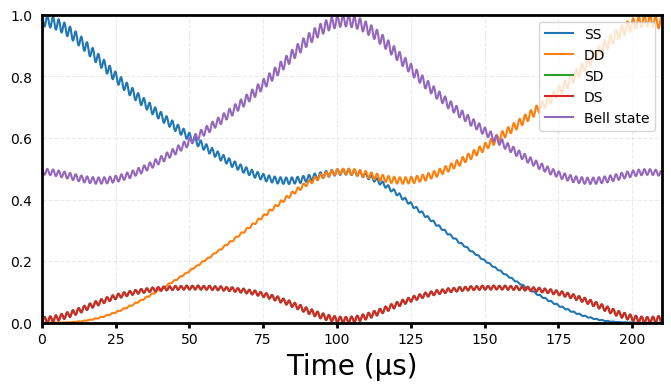

In [28]:
SS = ionprojector(chamber, "S", "S") 
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2) ⊗ one(mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

## Anti-correlated phase

### Update phase

In [33]:
phase!(laser1, -π/2)
phase!(laser2, π/2);

### Build the Hamiltonian / solve the system

In [34]:
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf);

In [35]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, ca["S"] ⊗ ca["S"] ⊗ mode[0], h);

  0.396818 seconds (3.24 M allocations: 115.232 MiB, 9.90% gc time)


### Plot results

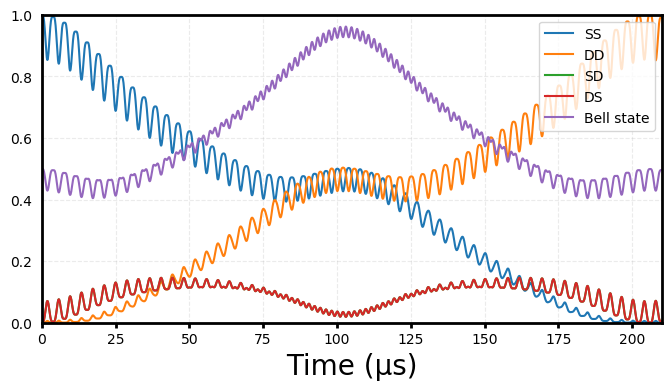

In [36]:
# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

## Anti-correlated phase with ramped laser intensity

### Update intensity profile

In [37]:
I = intensity_from_pitime(1, pi_time, 1, ("S", "D"), chamber)
# Simple amplitude ramping function
Ω = t -> t < 20 ? sin(2π * t / 80)^2 : 1

intensity!(laser1, t -> I*Ω(t)^2)
intensity!(laser2, t -> I*Ω(t)^2);

### Build the Hamiltonian / solve the system

In [38]:
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf);

In [40]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:220, ca["S"] ⊗ ca["S"] ⊗ mode[0], h);

  0.794465 seconds (5.62 M allocations: 159.405 MiB, 10.27% gc time, 4.17% compilation time)


### Plot results

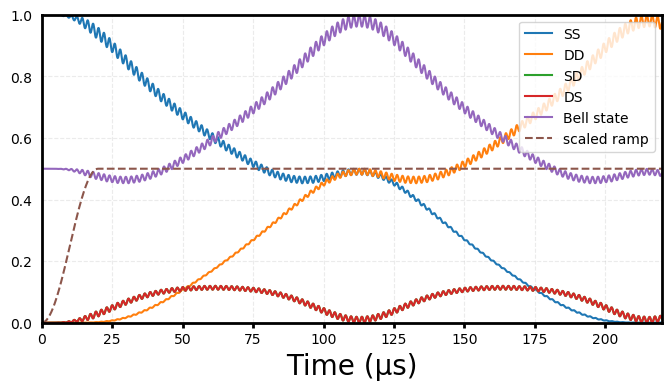

In [42]:
# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.plot(
        tout, @.(Ω(tout) / 2), 
        linestyle="--", label="scaled ramp"
    )
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

## Bibliography

```{bibliography} ramped_molmer_sorensen.bib
:filter: docname in docnames
```